<a href="https://colab.research.google.com/github/devash76/Automatic-Number-Plate-Recognition-System-ANPR-/blob/main/BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images_path = os.getcwd() + "/drive/MyDrive/Train Data/images/"
masks_path =  os.getcwd() + "/drive/MyDrive/Train Data/mask_result/"
images = os.listdir(images_path)
masks = os.listdir(masks_path)

# New Section

In [ ]:
dataset = pd.read_csv('drive/MyDrive/Train Data/train_data.csv')

In [ ]:
dataset.head()

,Image,Mask
0,ONB_aze_18950706_2.jpg,Mask_ONB_aze_18950706_2.jpg
1,ONB_aze_18950706_4.jpg,Mask_ONB_aze_18950706_4.jpg
2,ONB_aze_19110701_004.jpg,Mask_ONB_aze_19110701_004.jpg
3,ONB_aze_19110701_005.jpg,Mask_ONB_aze_19110701_005.jpg
4,ONB_aze_19110701_007.jpg,Mask_ONB_aze_19110701_007.jpg


In [ ]:
train_length = len(os.listdir(images_path))
batch_size = 2
buffer_size = 10
steps_per_epoch = train_length // batch_size
channels = 3
height = 1024
width = 1024

In [ ]:
from skimage.transform import resize
from tqdm import tqdm
import sys

In [ ]:
def image_generator(dataset,image_path,mask_path,train_length,img_shape):

  height,width,channels = img_shape
  X_train = np.zeros((train_length, height, width, channels), dtype=np.uint8)
  Y_train = np.zeros((train_length, height, width, 1), dtype=np.bool)
  kernel = np.ones((5,5),np.uint8)

  sys.stdout.flush()

  for n in tqdm(range(train_length), total=train_length):

    img = plt.imread(image_path + dataset.iloc[n][0])[:,:,:channels]
    img_resized = resize(img, (height, width), mode='constant', preserve_range=True)
    X_train[n] = img_resized

    mask = plt.imread(mask_path + dataset.iloc[n][1])[:,:,:1]
    mask_resized = resize(mask, (height, width), mode='constant', preserve_range=True)
    Y_train[n] = mask_resized

  return X_train,Y_train

In [ ]:
X_train,Y_train = image_generator(dataset,images_path,masks_path,train_length,(height,width,channels))
Y_train = Y_train.astype(np.float32)


100%|██████████| 40/40 [02:19<00:00,  3.50s/it]


In [ ]:
#Creating the Model

In [ ]:
def dice_coef(y_true,y_pred,epsilon=0.001):
  y_true_sum  = K.sum(y_true)
  y_pred_sum  = K.sum(y_pred)
  intersection = K.sum(y_true * y_pred)
  return ((2 * intersection + epsilon)/(y_true_sum + y_pred_sum + epsilon))

def dice_coef_loss(y_true,y_pred):
    return  1 - dice_coef(y_true,y_pred)

In [ ]:
#U-net Model from scratch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, concatenate
from tensorflow.keras.layers import Activation, BatchNormalization


In [ ]:
def unet(input_size=(256,256,3)):
    
    inputs = Input(input_size)
    x = Lambda(lambda x: x / 255)(inputs)
    
    #Contracting Path
    down_block_0_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(x)
    down_block_0_layer_0 = Activation("relu")(down_block_0_layer_0)
    down_block_0_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(down_block_0_layer_0)
    down_block_0_layer_1 = BatchNormalization(axis=3)(down_block_0_layer_1)
    down_block_0_layer_1 = Activation("relu")(down_block_0_layer_1)
    down_block_0_pool = MaxPool2D((2,2),strides=(2,2))(down_block_0_layer_1)
    
    down_block_1_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(down_block_0_pool)
    down_block_1_layer_0 = Activation("relu")(down_block_1_layer_0)
    down_block_1_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(down_block_1_layer_0)
    down_block_1_layer_1 = BatchNormalization(axis=3)(down_block_1_layer_1)
    down_block_1_layer_1 = Activation("relu")(down_block_1_layer_1)
    down_block_1_pool = MaxPool2D((2,2),strides=(2,2))(down_block_1_layer_1)
    
    down_block_2_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(down_block_1_pool)
    down_block_2_layer_0 = Activation("relu")(down_block_2_layer_0)
    down_block_2_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(down_block_2_layer_0)
    down_block_2_layer_1 = BatchNormalization(axis=3)(down_block_2_layer_1)
    down_block_2_layer_1 = Activation("relu")(down_block_2_layer_1)
    down_block_2_pool = MaxPool2D((2,2),strides=(2,2))(down_block_2_layer_1)
    
    down_block_3_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(down_block_2_pool)
    down_block_3_layer_0 = Activation("relu")(down_block_3_layer_0)
    down_block_3_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(down_block_3_layer_0)
    down_block_3_layer_1 = BatchNormalization(axis=3)(down_block_3_layer_1)
    down_block_3_layer_1 = Activation("relu")(down_block_3_layer_1)
    down_block_3_pool = MaxPool2D((2,2),strides=(2,2))(down_block_3_layer_1)
    
    down_block_4_layer_0 = Conv2D(256,kernel_size=(3,3),padding="same")(down_block_3_pool)
    down_block_4_layer_0 = Activation("relu")(down_block_4_layer_0)
    down_block_4_layer_1 = Conv2D(256,kernel_size=(3,3),padding='same')(down_block_4_layer_0)
    down_block_4_layer_1 = BatchNormalization(axis=3)(down_block_4_layer_1)
    down_block_4_layer_1 = Activation("relu")(down_block_4_layer_1)
    
    #Expanding Path
    up_block_0_upsample =  UpSampling2D((2,2))(down_block_4_layer_1)
    concat_block_0 =  concatenate([up_block_0_upsample,down_block_3_layer_1],axis=3)
    up_block_0_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(concat_block_0)
    up_block_0_layer_0 = Activation("relu")(up_block_0_layer_0)
    up_block_0_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(up_block_0_layer_0)
    up_block_0_layer_1 = BatchNormalization(axis=3)(up_block_0_layer_1)
    up_block_0_layer_1 = Activation("relu")(up_block_0_layer_1)
    
    up_block_1_upsample =  UpSampling2D((2,2))(up_block_0_layer_1)
    concat_block_1 =  concatenate([up_block_1_upsample,down_block_2_layer_1],axis=3)
    up_block_1_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(concat_block_1)
    up_block_1_layer_0 = Activation("relu")(up_block_1_layer_0)
    up_block_1_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(up_block_1_layer_0)
    up_block_1_layer_1 = BatchNormalization(axis=3)(up_block_1_layer_1)
    up_block_1_layer_1 = Activation("relu")(up_block_1_layer_1)
    
    up_block_2_upsample =  UpSampling2D((2,2))(up_block_1_layer_1)
    concat_block_2 =  concatenate([up_block_2_upsample,down_block_1_layer_1],axis=3)
    up_block_2_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(concat_block_2)
    up_block_2_layer_0 = Activation("relu")(up_block_2_layer_0)
    up_block_2_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(up_block_2_layer_0)
    up_block_2_layer_1 = BatchNormalization(axis=3)(up_block_2_layer_1)
    up_block_2_layer_1 = Activation("relu")(up_block_2_layer_1)
    
    up_block_3_upsample =  UpSampling2D((2,2))(up_block_2_layer_1)
    concat_block_3 =  concatenate([up_block_3_upsample,down_block_0_layer_1],axis=3)
    up_block_3_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(concat_block_3)
    up_block_3_layer_0 = Activation("relu")(up_block_3_layer_0)
    up_block_3_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(up_block_3_layer_0)
    up_block_3_layer_1 = BatchNormalization(axis=3)(up_block_3_layer_1)
    up_block_3_layer_1 = Activation("relu")(up_block_3_layer_1)
        

    outputs = Conv2D(1,(1,1),activation="sigmoid")(up_block_3_layer_1)
    
    return Model(inputs = [inputs], outputs = [outputs])

In [ ]:
model = unet(input_size=(height,width,channels))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1024, 1024, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 1024, 1024, 1 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 1024, 1024, 1 0           conv2d_38[0][0]                  
____________________________________________________________________________________________

In [ ]:
epochs = 250
steps_per_epoch = train_length // batch_size
batch_size = 2
learning_rate = 1e-4

In [ ]:
os.mkdir(os.getcwd() +"/drive/MyDrive/Train Data/Models/Checkpoints_BN")

In [ ]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('loss') < 0.020):
      print("Model loss reached, so stop training!!")
      self.model.stop_training = True
      

In [ ]:
checkpoint_path = os.getcwd() +"/drive/MyDrive/Train Data/Models/Checkpoints_BN/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             save_weights_only = True,
                             verbose=1)

callback = Callback()


model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
decay_rate = learning_rate / epochs
opt = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

In [ ]:
model.compile(optimizer=opt,loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
results_2 = model.fit(X_train, Y_train, validation_split=0.1,batch_size=batch_size, epochs=epochs,callbacks=[checkpoint,callback])

Epoch 179/250
12/18 [===================>..........] - ETA: 4s - loss: 0.0243 - dice_coef: 0.9757 - accuracy: 0.9976

KeyboardInterrupt: ignored

In [ ]:
test_path ="/content/drive/MyDrive/Train Data/test_data/test_images"

In [ ]:
img = plt.imread("/content/drive/MyDrive/Train Data/test_data/test_images/ONB_nfp_19110701_012.jpg")[:,:,:channels]
img_resized = resize(img, (height, width), mode='constant', preserve_range=True)
img_test = img_resized.reshape((1,height,width,channels)).astype(np.uint8)
pred = model.predict(img_test)
pred = (pred > 0.5).astype(np.uint8)

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(img_test.squeeze(),cmap='gray')
plt.title('Mask')
plt.subplot(122)
plt.imshow(pred.squeeze(),cmap='gray')
plt.title('Predicted Mask')
plt.suptitle('Model 2')
plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/model2_pred.jpg")

In [ ]:
loss_2 = results_2.history['loss']
dice_coeff_2 = results_2.history['dice_coef']
accuracy_2 = results_2.history['accuracy']
val_loss_2 = results_2.history['val_loss']
val_dice_coeff_2 = results_2.history['val_dice_coef']
val_accuracy_2 = results_2.history['val_accuracy']

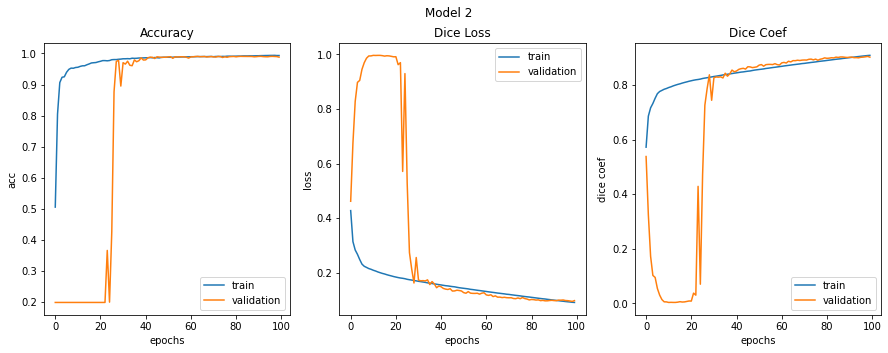

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(accuracy_2,label='training accuracy')
plt.plot(val_accuracy_2,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['train','validation'])
plt.title('Accuracy')
plt.subplot(132)
plt.plot(loss_2,label='training loss')
plt.plot(val_loss_2,label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.title('Dice Loss')
plt.subplot(133)
plt.plot(dice_coeff_2,label='training dice coef')
plt.plot(val_dice_coeff_2,label='validation dice coef')
plt.xlabel('epochs')
plt.ylabel('dice coef')
plt.legend(['train','validation'])
plt.title('Dice Coef')
plt.suptitle('Model 2')
plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/model2.jpg")

# **Testing**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import tensorflow.keras.backend as K
import sys
from tqdm import  tqdm
from skimage.transform import resize

In [ ]:
dataset_path = "/content/drive/MyDrive/Train Data/test_data/"
image_path = dataset_path + "test_images/"
mask_path = dataset_path + "test_masks/"
img_shape = (1024,1024,3)

In [ ]:
images = os.listdir(image_path)
masks  = os.listdir(mask_path)
images.sort()
masks.sort()
test_set = pd.DataFrame({'images': np.array(images),'masks':np.array(masks)})

In [ ]:
img = cv2.imread(image_path + images[1])
mask = cv2.imread(mask_path + masks[1])

In [ ]:
def display(img):
  plt.figure(figsize=(12,8))
  plt.subplot(111)
  plt.imshow(img,cmap="gray")
  plt.show()

In [ ]:
kernel = np.ones((5,5),np.uint8)
img_morph = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

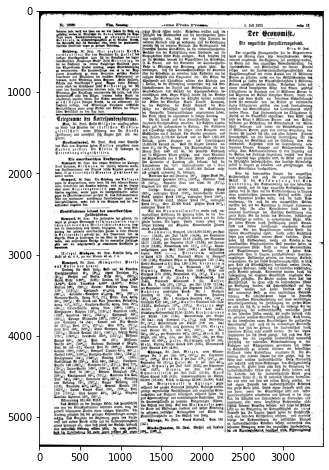

In [ ]:
display(img_morph)

In [ ]:
def test_generator(image,mask,train_length,img_shape):

  height,width,channels = img_shape
  X_test = np.zeros((train_length, height, width, channels), dtype=np.uint8)
  Y_test = np.zeros((train_length, height, width, 1), dtype=np.bool)

  sys.stdout.flush()

  for n in tqdm(range(train_length), total=train_length):

    image = image[:,:,:channels]
    img_resized = resize(image, (height, width), mode='constant', preserve_range=True)
    X_test[n] = img_resized

    mask = mask[:,:,:1]
    mask_resized = resize(mask, (height, width), mode='constant', preserve_range=True)
    Y_test[n] = mask_resized

  return X_test,Y_test

In [ ]:
X_test_morph,Y_test_morph = test_generator(img_morph,mask,1,img_shape)
Y_test_morph = Y_test_morph.astype(np.float32)

100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


In [ ]:
def dice_coef(y_true,y_pred,epsilon=0.001):
  y_true_sum  = K.sum(y_true)
  y_pred_sum  = K.sum(y_pred)
  intersection = K.sum(y_true * y_pred)
  return ((2 * intersection + epsilon)/(y_true_sum + y_pred_sum + epsilon))

def dice_coef_loss(y_true,y_pred):
    return  1 - dice_coef(y_true,y_pred)

In [ ]:
def test_results(images,masks,model,name):
  for image,mask in zip(images,masks):
    image = image.reshape(1,1024,1024,3)
    mask_pred = model.predict(image)
    mask_pred = (mask_pred > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(24,20))
    plt.subplot(131)
    plt.imshow(image.squeeze())
    plt.title("Text Document")
    plt.subplot(132)
    plt.imshow(mask.squeeze(),cmap='gray')
    plt.title("Original Mask")
    plt.subplot(133)
    plt.imshow(mask_pred.squeeze(),cmap='gray')
    plt.title('Predicted Mask')
    plt.savefig(f"/content/drive/MyDrive/Train Data/{name}")

In [ ]:
latest_weights = tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
model = unet(input_size=img_shape)
model.load_weights(latest_weights)

In [ ]:
model.compile(optimizer=opt,loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])

In [ ]:
results = model.evaluate(X_test_morph,Y_test_morph)

1/1 [==============================] - 1s 830ms/step - loss: 0.0973 - dice_coef: 0.9027 - accuracy: 0.9865


In [ ]:
model1_path = "/content/drive/MyDrive/Train Data/Models/text_block_model_morph_1024*1024.h5"

In [ ]:
model1 = tf.keras.models.load_model(model1_path,custom_objects={'dice_coef':dice_coef,'dice_coef_loss':dice_coef_loss})

OSError: ignored

In [ ]:
results1 = model1.evaluate(X_test_morph,Y_test_morph)

TypeError: ignored

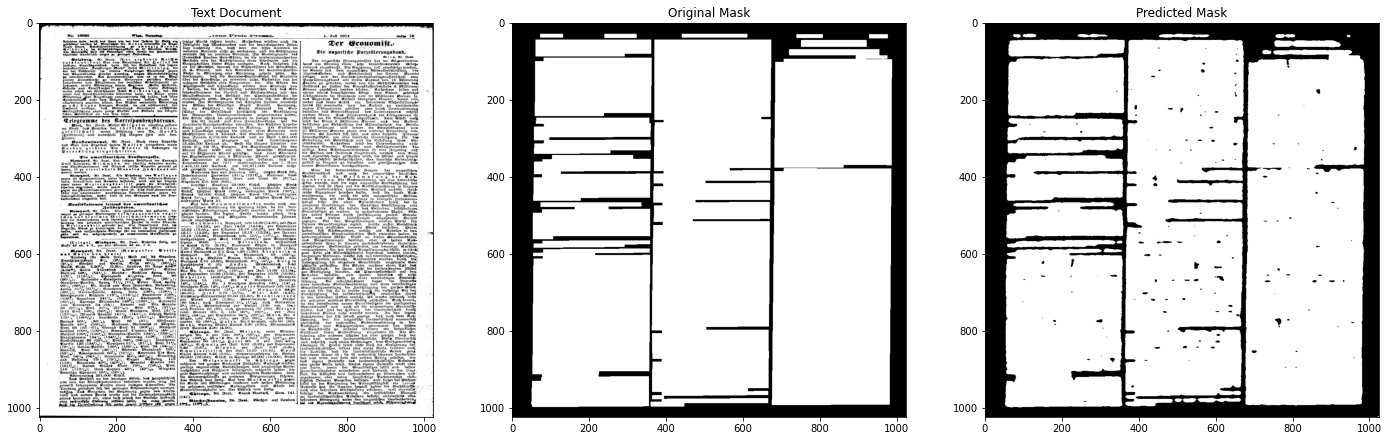

In [ ]:
test_results(X_test_morph,Y_test_morph,model1,"with morph")

In [ ]:
def image_generator(dataset,image_path,mask_path,train_length,img_shape):

  height,width,channels = img_shape
  X_test = np.zeros((train_length, height, width, channels), dtype=np.uint8)
  Y_test = np.zeros((train_length, height, width, 1), dtype=np.bool)

  sys.stdout.flush()

  for n in tqdm(range(train_length), total=train_length):

    img = plt.imread(image_path + dataset.iloc[n][0])[:,:,:channels]
    img_resized = resize(img, (height, width), mode='constant', preserve_range=True)
    X_test[n] = img_resized

    mask = plt.imread(mask_path + dataset.iloc[n][1])[:,:,:1]
    mask_resized = resize(mask, (height, width), mode='constant', preserve_range=True)
    Y_test[n] = mask_resized

  return X_test,Y_test

In [ ]:
X_test, Y_test = image_generator(test_set,image_path,mask_path,len(images),img_shape)
Y_test = Y_test.astype(np.float32)

100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


In [ ]:
results = model.evaluate(X_test,Y_test)

1/1 [==============================] - 5s 5s/step - loss: 0.0514 - dice_coef: 0.9486 - accuracy: 0.9909


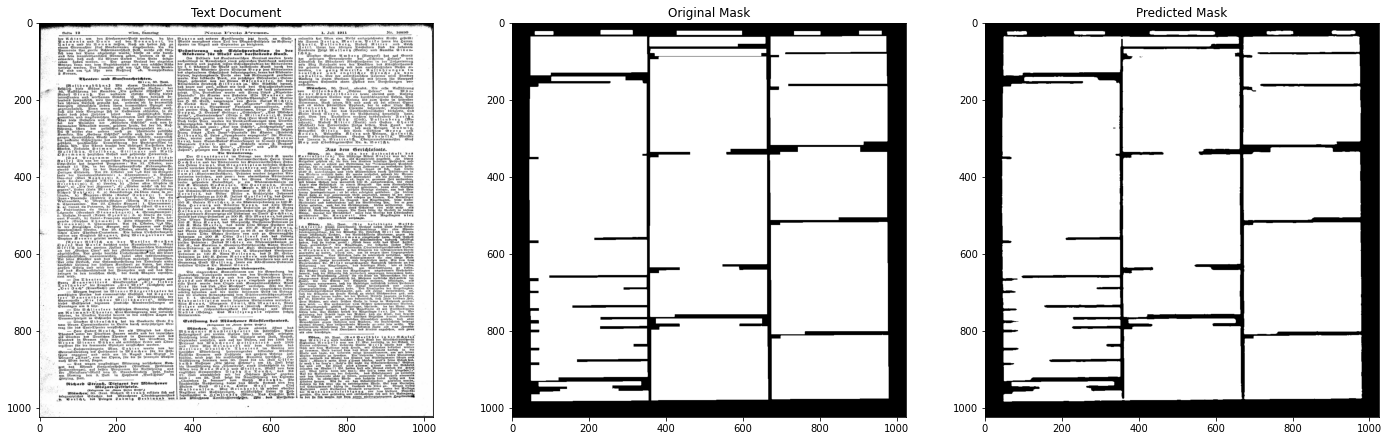

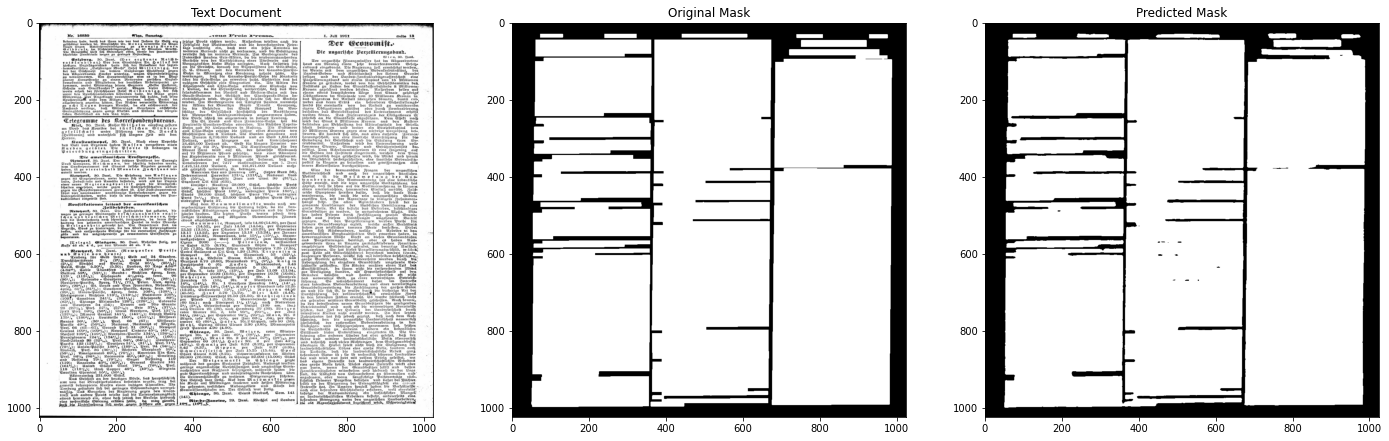

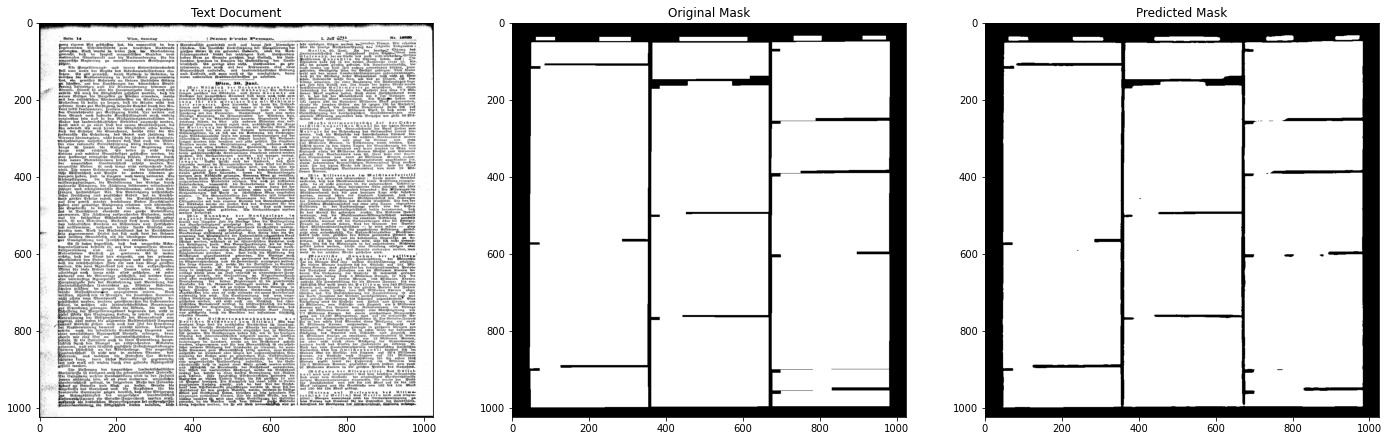

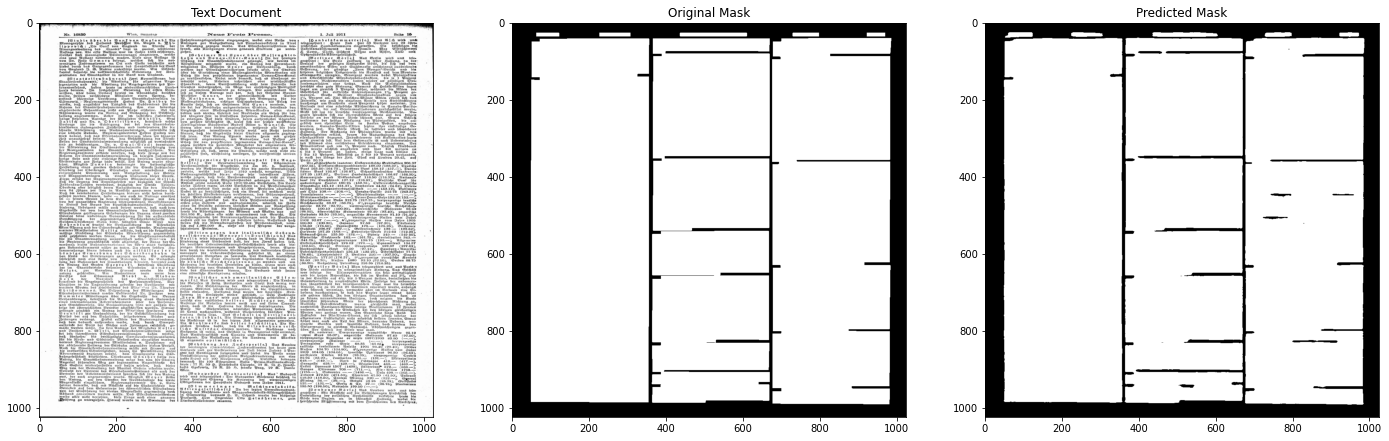

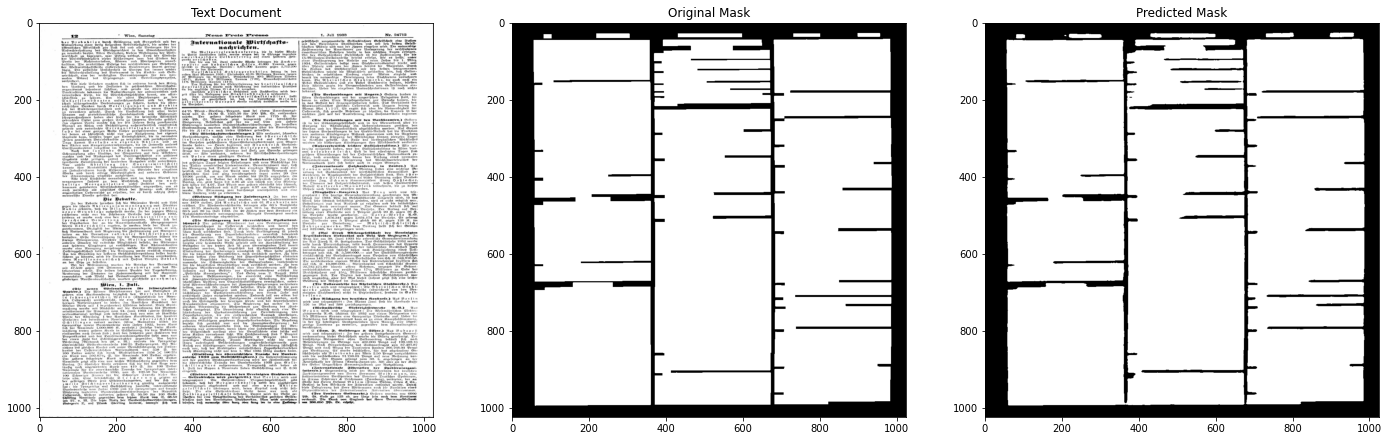

In [ ]:
test_results(X_test,Y_test,model,"with morph")